In [ ]:
"""
Projet reconaissance d'une langue

Référent : Ciao Corro

Groupe :
ALLOUANE Yohann
BENBOUZIANE Adame
BERRAMDANE Salah-Eddine
ICIL Bilal
POISSON Guillaume
RENCIOT Antoine
"""

In [2]:
import numpy as np
import pandas as pd
import csv
import re
import unicodedata
from string import punctuation
from string import digits
import string
import copy
from matplotlib.ticker import MultipleLocator; 
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm

filename = 'dataset.csv'
dataset = pd.read_csv(filename)
language = ["Dutch","English","French","Estonian","Indonesian","Latin","Portugese","Romanian","Spanish","Swedish","Turkish"]
X = dataset.values.tolist()
x,y = dataset["Text"],dataset["language"]

data = list(filter(lambda x: x[1] in language,X)) #On garde que les langues avec un  alphabet latin
newlist = [[y for y in X if y[1]==x] for x in language] #Textes groupés par langue
for lang in newlist:
    print(lang[0][1]," nombre de textes ",len(lang))

Dutch  nombre de textes  1000
English  nombre de textes  1000
French  nombre de textes  1000
Estonian  nombre de textes  1000
Indonesian  nombre de textes  1000
Latin  nombre de textes  1000
Portugese  nombre de textes  1000
Romanian  nombre de textes  1000
Spanish  nombre de textes  1000
Swedish  nombre de textes  1000
Turkish  nombre de textes  1000


In [3]:



corpus = []
all2gram = []
all3gram = []

#On récupère tous les 3-grammes, 2-grammes, 1-grammes.
for letter in string.ascii_lowercase+" ":
    for letter2 in string.ascii_lowercase+" ":
        all2gram.append(letter+letter2)
        for letter3 in string.ascii_lowercase+" ":
            all3gram.append(letter+letter2+letter3)


"""On initialise les features à 1 pour le lissage additif. On va prétendre que chaques 3-grammes,2-grammes,1-grammes 
a été vu une fois.   """      
features1gram = dict.fromkeys(string.ascii_lowercase+" ", 1)
features2gram = { i : 1 for i in all2gram }
features3gram = {i : 1 for i in all3gram}


specialChar = list(punctuation+'\n'+'«'+'»')
remove_digits = str.maketrans('', '', digits)
pattern = "^[a-zA-Z]"




def replace_all(text, dic,char):
    for x in dic:
        text = text.replace(x, char)
    return text

def remove_all(text, dic):
    return replace_all(text, dic,'')


# Calcule P(c3 | c1,c2,l)
def proba3gram(c1,c2,c3,l):
    dict3 = l[4]
    count3 = l[7]
    w = ((dict3[c1+c2+c3])/count3)
    pre = c1+c2
    s = 0
    for x in features1gram:
        s = s + ((dict3[c1+c2+x]/count3))
    V = len(features1gram)
    return w/(s)

# Calcule P(c2 | c1,l)
def proba2gram(c1,c2,l):
    dict2 = l[3]
    count2 = l[6]
    w = ((dict2[c1+c2])/count2)
    pre = c1
    s = 0
    for x in features1gram:
        s = s + ((dict2[c1+x]/count2)) 
    V = len(features1gram)
    return (w)/(s)

# Calcule P(c1|l)
def proba1gram(c1,l):
    dict1 = l[2]
    count1 = l[5]
    w=dict1[c1]
    s = count1
    return w/s
 
#Calcule P(texte | l)
def probaText(text,l):
    n = len(text)
    w1 = np.log(proba1gram(text[0],l))
    w2 = np.log(proba2gram(text[0],text[1],l))
    p = 0
    for i in range(2,len(text)):
        p +=  np.log(proba3gram(text[i-2], text[i-1],text[i],l))
    return w1+w2+p

#Calcule pour chaque langue la probabilité du texte, on retourne la plus haute probabilité.
def predict(text,models):
    pred = []
    for lang in models:
        pred.append(probaText(text,lang)+(nbTrain/(nbTrain*len(language))))
    result =np.argmax(pred)
    return models[result][0]

# Pré-traitement des textes
for lang in newlist:
    l = [lang[0][1],[]]
    for text in lang:
        lower = text[0].lower() #On met les textes en minuscule
        latinText = unicodedata.normalize('NFKD',''.join(lower)).encode('ascii', 'ignore').decode("utf-8").lower() #Convertis en équivalent latin
        t = remove_all(latinText,specialChar) #On enlève la ponctuaction
        cleanText = re.sub(pattern,"",t).lower() #On enlève les caractères spéciaux
        noDigit = cleanText.translate(remove_digits) # On enlève les nombres des textes
        l[1].append(noDigit)
    corpus.append(l)





Taux de précision train :  0.9857142857142858


<ipython-input-5-158367736918>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
<ipython-input-5-158367736918>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


Taux de précision test :  0.9757575757575757
French


<ipython-input-5-158367736918>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+ labels)
<ipython-input-5-158367736918>:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+ labels)


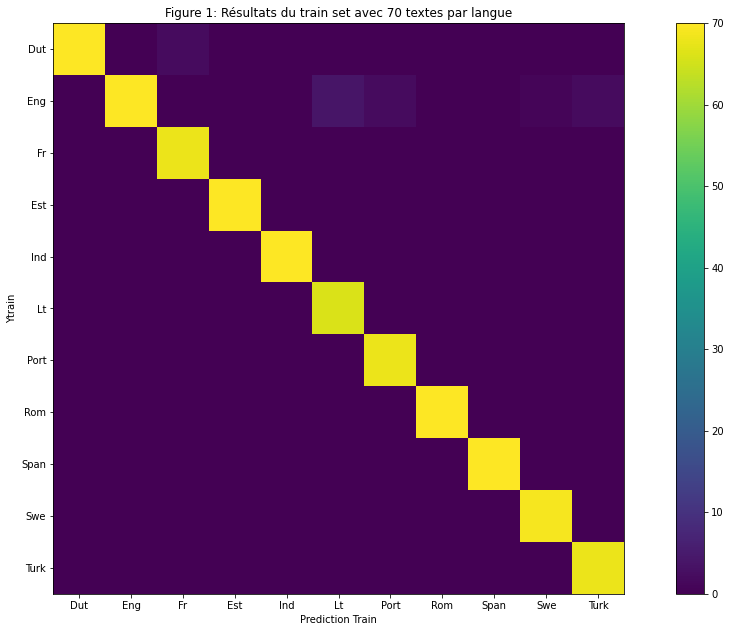

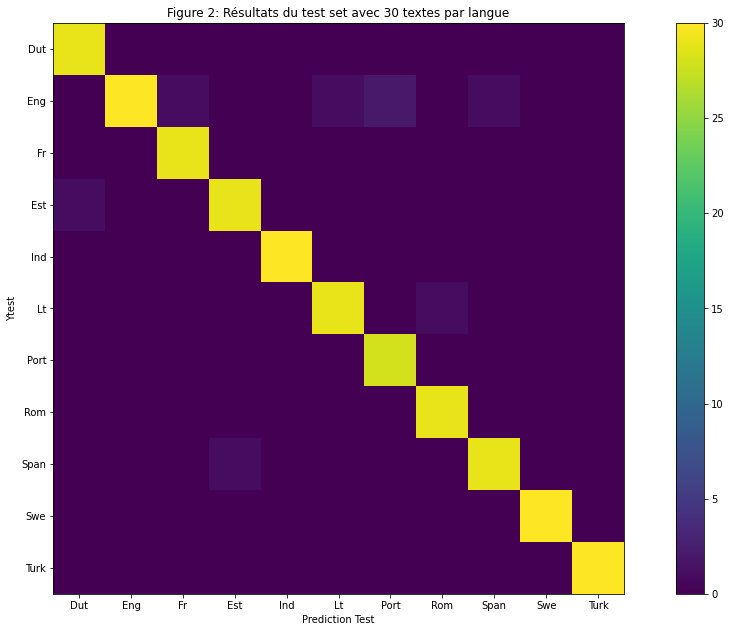

In [5]:
Iteration = 1
"""
Nombre d'itération pour chaque itération on ajoute 100 textes par langue.
L'algorithme peut être très long (20-30 minutes pour 10 itérations)
"""
graphTest = np.zeros((Iteration,2)) #Les tableaux qui vont nous servir pour le graphique des résultats.
graphTrain = np.zeros((Iteration,2)) 
for it in range(1,Iteration+1):
    nb = it * 100 # Nombre de textes par langue
    nbTrain = int(nb*0.70) # 70% de train
    nbTest = int(nb*0.30) # 30% de test
    
    #On prépare les données d'entrainement.
    data = []
    for lang in corpus:
            l = []
            l.append(lang[0])
            l.append(lang[1])
            l.append(copy.copy(features1gram))
            l.append(copy.copy(features2gram))
            l.append(copy.copy(features3gram))
            l.append(0)
            l.append(0)
            l.append(0)
            for text in l[1][0:nbTrain]:    
                for key in features1gram:
                    l[2][key] = l[2][key] + text.count(key)
                    l[5] =   l[5] + l[2][key]
                for key in features2gram:
                    l[3][key] = l[3][key] + text.count(key)
                    l[6] = l[6] + l[3][key] 
                for key in features3gram:
                    l[4][key] =  l[4][key] + text.count(key) 
                    l[7] = l[7] +l[4][key]
            data.append(l)
            
            
            
    #On prépare les données pour les tests
    Xtest = []
    Xtrain = []
    Ytest = []
    Ytrain = []
    for lang in corpus:
        for text in lang[1][nbTrain:nbTrain+nbTest]:
                Ytest.append(lang[0])
                Xtest.append(text)

    for lang in corpus:
        for text in lang[1][0:nbTrain]:  
                Ytrain.append(lang[0])
                Xtrain.append(text)

    #On test avec les données d'entrainement.
    YpredTrain = []
    for x in Xtrain:
        YpredTrain.append(predict(x,data))
    
    tError = sklearn.metrics.accuracy_score(YpredTrain, Ytrain)
    labels = ["Dut","Eng","Fr","Est","Ind","Lt","Port","Rom","Span","Swe","Turk"]
    print("Taux de précision train : ",tError)
    graphTrain[it-1][0] = nb
    graphTrain[it-1][1] = tError

    #Matrice graphique pour les résultats avec les données de train
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    plt.xlabel("Prediction Train")
    plt.ylabel("Ytrain")
    ax.set_title('Figure 1: Résultats du train set avec '+str(nbTrain)+' textes par langue')
    confmat = sklearn.metrics.confusion_matrix(YpredTrain, Ytrain)
    plt.imshow(confmat)
    plt.colorbar() 
    
    #On test avec les données de test.
    YpredTest = []
    for x in Xtest:
        YpredTest.append(predict(x,data))
        
    tError = sklearn.metrics.accuracy_score(YpredTest, Ytest)
    print("Taux de précision test : ",tError)
    graphTest[it-1][0] = nb
    graphTest[it-1][1] = tError
    
    #Matrice graphique pour les résultats avec les données de test
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(['']+ labels)
    ax.set_yticklabels(['']+ labels)
    plt.xlabel("Prediction Test")
    plt.ylabel("Ytest")
    ax.set_title('Figure 2: Résultats du test set avec '+str(nbTest)+' textes par langue')
    confmat = sklearn.metrics.confusion_matrix(YpredTest, Ytest)
    plt.imshow(confmat)
    plt.colorbar()
    
    print(predict("salut a tous",data))
    

    
          


In [7]:
print(predict("hello everyone",data))

English


[[1.00000000e+02 9.85714286e-01]
 [2.00000000e+02 9.83766234e-01]
 [3.00000000e+02 9.80952381e-01]
 [4.00000000e+02 9.81168831e-01]
 [5.00000000e+02 9.79740260e-01]
 [6.00000000e+02 9.78571429e-01]
 [7.00000000e+02 9.78620561e-01]
 [8.00000000e+02 9.78084416e-01]
 [9.00000000e+02 9.77633478e-01]
 [1.00000000e+03 9.77792208e-01]]
[[1.00000000e+02 9.75757576e-01]
 [2.00000000e+02 9.71212121e-01]
 [3.00000000e+02 9.72727273e-01]
 [4.00000000e+02 9.67424242e-01]
 [5.00000000e+02 9.70303030e-01]
 [6.00000000e+02 9.71717172e-01]
 [7.00000000e+02 9.74891775e-01]
 [8.00000000e+02 9.76515152e-01]
 [9.00000000e+02 9.78787879e-01]
 [1.00000000e+03 9.78181818e-01]]


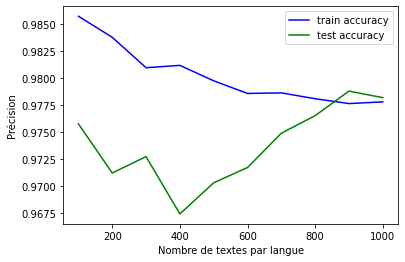

In [416]:


#Line chart résultats en fonction des itérations
plt.figure(2)
plt.xlabel("Nombre de textes par langue")
plt.ylabel("Précision")
plt.plot(graphTrain.transpose()[0], graphTrain.transpose()[1], label='train accuracy',color='blue')
plt.plot(graphTest.transpose()[0], graphTest.transpose()[1], label='test accuracy',color='green')
plt.legend()


   

In [13]:


#Cette fois-ci pas de lissage additif
features3gram = {i : 0 for i in all3gram}

#Calcule le nombre de 3-grammes dans le texte
def seq_ngrams(xs, n):
    return len([xs[i:i+n] for i in range(len(xs)-n+1)])

# Notre modèle y = Wx

def model(W, X):
    Y = []
    for i in range(len(X)):
        x= X[i]
        y = np.zeros(len(language),dtype=int)
        r = np.argmax((np.matmul(W,x)))
        y[r] = 1
        Y.append(y)
    return Y

#Cacule du gradient.
def gradient(X, Y, W):
    s = 0
    for i in range(len(X)):
        x= X[i]
        y= Y[i]
        ypred = np.matmul(W,x) 
        mask = np.zeros(ypred.size, dtype=bool)
        exceptIndex = np.argmax(y)
        mask[exceptIndex] = True
        masked = np.ma.array(ypred, mask=mask)
        maxy = np.argmax(masked)
        a = ypred[maxy] + m - ypred[exceptIndex]
        z = np.zeros(ypred.size, dtype=int)
        z[maxy] = 1
        z = np.array([z])
        y =  np.array([y])
        x = np.array([x])
        if a > 0:
            s += np.matmul(z.transpose(),x)  - np.matmul(y.transpose(),x) 
    return s

#Descente du gradient.
def fit(eta, MaxIter, Winitial, X, Y):
    W = Winitial.copy()
    Wliste = []
    Wliste.append(W)
    trainError = np.zeros(MaxIter)
    for iteration in range(MaxIter):
        trainError[iteration] =1-sklearn.metrics.accuracy_score(Y,model(W,X))
        W = W -  eta * gradient(X,Y,W)
        Wliste.append(W)
    return Wliste, trainError


#On initialise notre matrice W aléatoirement. La matrice est de taille Nblangues * NbFeatures
Winitial = np.random.random((11, 100))
#Notre marge
m = 5



Taux de précision train :  0.6454545454545455
Taux de précision test :  0.5303030303030303


<ipython-input-14-d6c22ed0ece6>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
<ipython-input-14-d6c22ed0ece6>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)
<ipython-input-14-d6c22ed0ece6>:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
<ipython-input-14-d6c22ed0ece6>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


Taux de précision train :  0.6194805194805195
Taux de précision test :  0.543939393939394


<ipython-input-14-d6c22ed0ece6>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
<ipython-input-14-d6c22ed0ece6>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)
<ipython-input-14-d6c22ed0ece6>:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
<ipython-input-14-d6c22ed0ece6>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


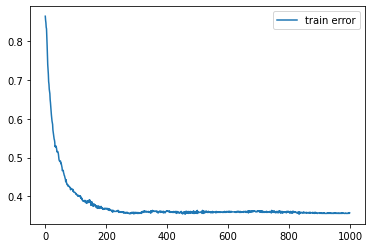

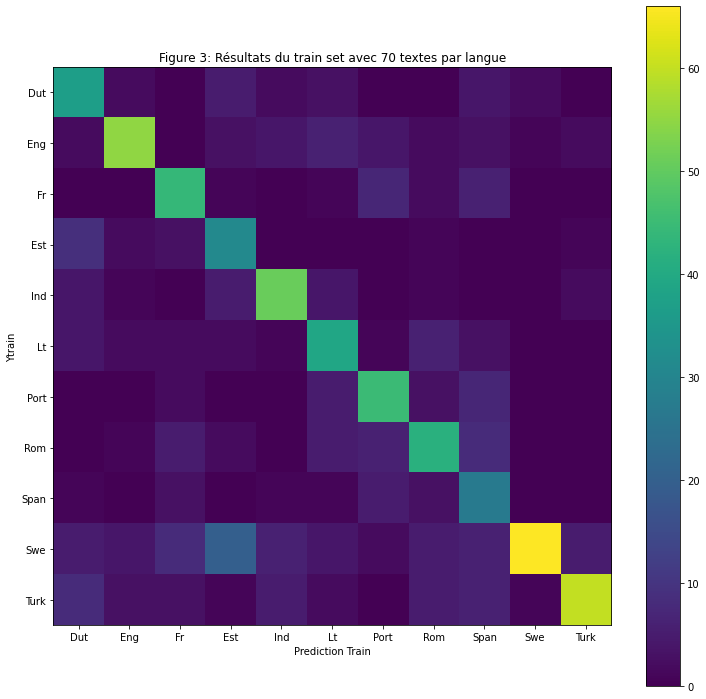

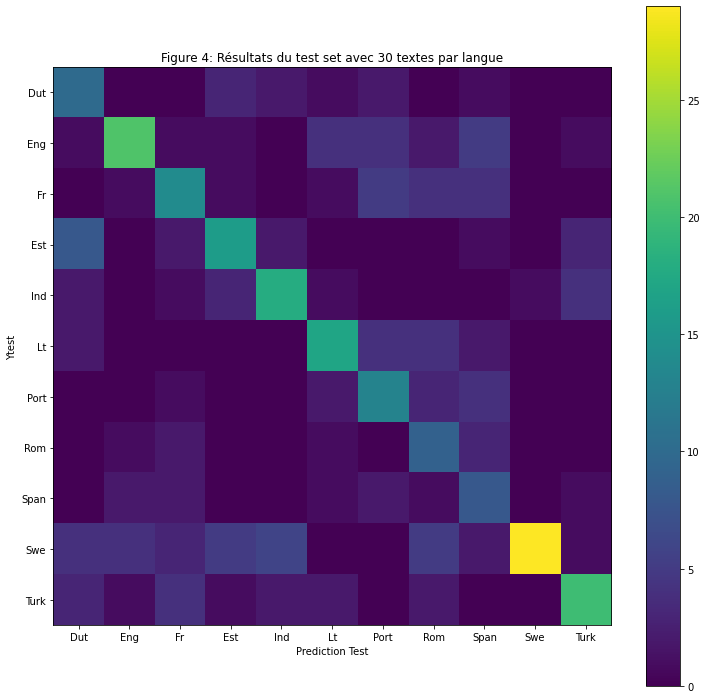

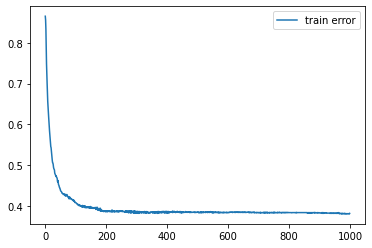

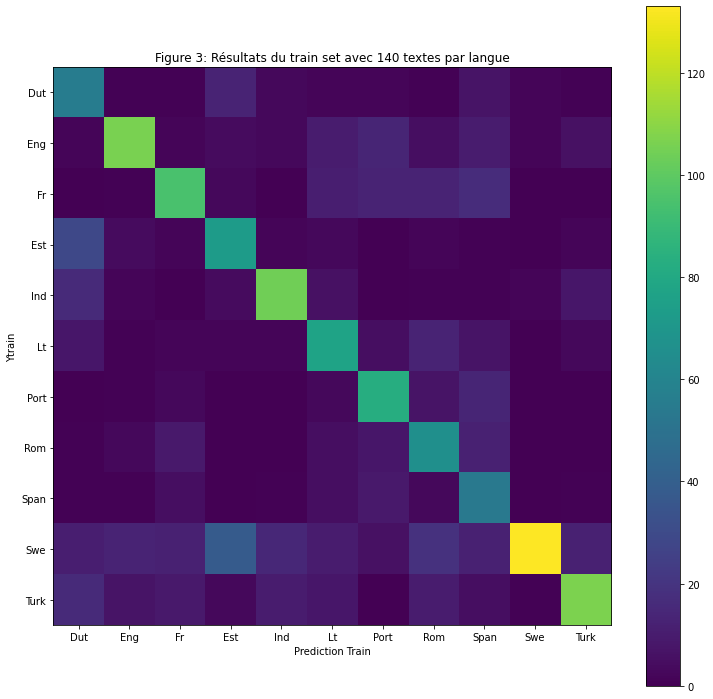

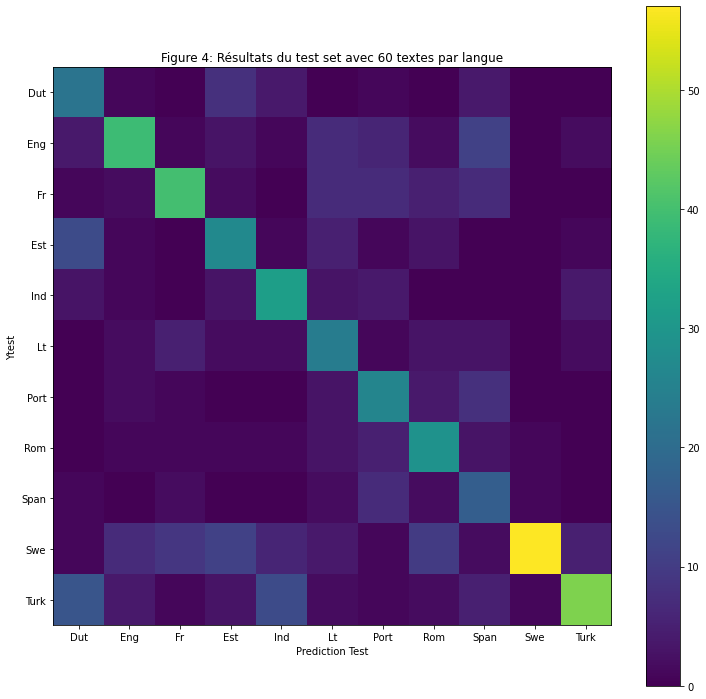

In [14]:
Iteration = 2 
"""Même chose que pour les N-grammes"""
graphTest = np.zeros((Iteration,2))
graphTrain = np.zeros((Iteration,2))
for it in range(1,Iteration+1):
    
    
    sumFrequence = copy.copy(features3gram) #
    dataSVM = []
    nb = 100*it
    nbTrain = int(nb*0.70)
    nbTest = int(nb*0.30)
  
    #On calcule les fréquences des textes
    for lang in corpus:
        for text in lang[1][0:nbTrain]:
            l = []
            sum3gram = seq_ngrams(text, 3)
            l.append(lang[0])
            l.append(text)
            l.append(copy.copy(features3gram))
            for key in features3gram:
                    l[2][key] =  + text.count(key)/sum3gram
                    sumFrequence[key] += l[2][key]
            dataSVM.append(l)

    # On garde les 100 fréquences de 3-grammes les plus hautes 
    top100 = sorted(sumFrequence)[0:100]
    
    #On prépare les données d'entrainement
    Xtrain = []
    language = np.array(["Dutch","English","French","Estonian","Indonesian","Latin","Portugese","Romanian","Spanish","Swedish","Turkish"])
    Ytrain = []
    for x in dataSVM:
        Y = np.zeros(len(language),dtype=int)
        Y[np.argwhere(language == x[0])] = 1
        Ytrain.append(Y)
        X = np.zeros(len(top100))
        for i in range(len(top100)):
            key = top100[i]
            X[i] = x[2][key]
        Xtrain.append(X)

    
    eta = 0.1 #On fait des sauts de 0.1
    MaxIter = 1000 #Nombre de sauts
    Wliste, trainError = fit(eta,MaxIter,Winitial,Xtrain,Ytrain) 
    
    #Graphique des taux d'erreurs pour chaque itérations 
    epoques = np.arange(MaxIter)
    plt.figure()
    plt.plot(epoques, trainError, label='train error')
    plt.legend()

    #On veut la matrice W tel que le taux d'erreurs est le plus bas
    minW = np.argmin(trainError)
    W = Wliste[minW]

    
    #On prépare les données de test
    Xtest = []
    Ytest = []
    YpredTest = []
    YpredTrain = []

    for lang in corpus:
        for text in lang[1][nbTrain:nbTrain+nbTest]:
            sum3gram = seq_ngrams(text, 3)
            Y = np.zeros(len(language),dtype=int)
            Y[np.argwhere(language == lang[0])] = 1
            X = np.zeros(len(top100))
            for i in range(len(top100)):
                key = top100[i]
                X[i] = text.count(key)/sum3gram
            Xtest.append(X)
            Ytest.append(Y)

    #On test avec les données d'entrainement.
    YpredTrain = model(W,Xtrain)

    
    tError = sklearn.metrics.accuracy_score(YpredTrain, Ytrain)
    labels = ["Dut","Eng","Fr","Est","Ind","Lt","Port","Rom","Span","Swe","Turk"]
    print("Taux de précision train : ",tError)
    graphTrain[it-1][0] = nb
    graphTrain[it-1][1] = tError
    
    
    #Matrice graphique pour les résultats avec les données de train
    fig = plt.figure(figsize=(11, 11))
    fig.set_size_inches(12.5,12.5)
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(MultipleLocator(1)); 
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    plt.xlabel("Prediction Train")
    plt.ylabel("Ytrain")
    ax.set_title('Figure 3: Résultats du train set avec '+str(nbTrain)+' textes par langue')
    confmat = sklearn.metrics.confusion_matrix(list(map(np.argmax,YpredTrain)),list(map(np.argmax, Ytrain)))
    plt.imshow(confmat)
    plt.colorbar()

    YpredTest = []
    #On test avec les données d'entrainement.
    YpredTest = model(W,Xtest)
        
    tError = sklearn.metrics.accuracy_score(YpredTest, Ytest)
    print("Taux de précision test : ",tError)
    graphTest[it-1][0] = nb
    graphTest[it-1][1] = tError
    
    #Matrice graphique pour les résultats avec les données de train
    fig = plt.figure()
    fig.set_size_inches(12.5,12.5)
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(MultipleLocator(1)); 
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    plt.xlabel("Prediction Test")
    plt.ylabel("Ytest")
    ax.set_title('Figure 4: Résultats du test set avec '+str(nbTest)+' textes par langue')
    confmat = sklearn.metrics.confusion_matrix(list(map(np.argmax,YpredTest)), list(map(np.argmax,Ytest)))
    plt.imshow(confmat)
    plt.colorbar()

[[1.00000000e+02 6.48051948e-01]
 [2.00000000e+02 6.16883117e-01]
 [3.00000000e+02 6.12554113e-01]
 [4.00000000e+02 6.04545455e-01]
 [5.00000000e+02 6.00519481e-01]
 [6.00000000e+02 5.98268398e-01]
 [7.00000000e+02 5.97322922e-01]
 [8.00000000e+02 5.97240260e-01]
 [9.00000000e+02 5.96825397e-01]
 [1.00000000e+03 6.02337662e-01]]
[[1.00000000e+02 5.30303030e-01]
 [2.00000000e+02 5.43939394e-01]
 [3.00000000e+02 5.61616162e-01]
 [4.00000000e+02 5.56060606e-01]
 [5.00000000e+02 5.76969697e-01]
 [6.00000000e+02 5.78787879e-01]
 [7.00000000e+02 5.84848485e-01]
 [8.00000000e+02 5.98863636e-01]
 [9.00000000e+02 5.92592593e-01]
 [1.00000000e+03 5.90606061e-01]]


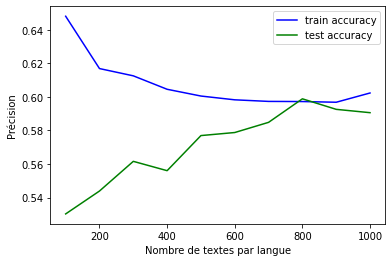

In [78]:

#Line chart résultats en fonction des itérations
plt.figure(2)
plt.xlabel("Nombre de textes par langue")
plt.ylabel("Précision")
plt.plot(graphTrain.transpose()[0], graphTrain.transpose()[1], label='train accuracy',color='blue')
plt.plot(graphTest.transpose()[0], graphTest.transpose()[1], label='test accuracy',color='green')
plt.legend()
